<h1 style="color:rgb(92, 11, 10)">Assignment 3: Continuous Evaluation with Kafka</h1>


## Part 1: Static model

------------------------------------------------

## Libraries 

In [1]:
#! pip install xgboost
# !pip install seaborn --upgrade
# !pip install matplotlib --upgrade

In [2]:
# 1.Data Analysis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.figure(figsize=(12,16))
# 2.Feature engineering and data cleaning
from sklearn.preprocessing import LabelEncoder

# 3.Feature Filtering/Selection
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif, chi2, f_classif
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import f1_score
import numpy as np

# 4.Model Training
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, make_scorer
from sklearn.model_selection import cross_val_score, cross_validate ,cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# 5.Model evaluation



<Figure size 864x1152 with 0 Axes>

--------------------

## Functions

<h4 style="color:rgb(49, 58, 74)"> 1.Data Analysis</h4>

In [3]:
def read_csv(file_name):
    data = pd.read_csv(file_name)
    shape = data.shape
    return data , shape

In [4]:
def get_info(dataset):
    """
    input  : the whole dataset with all features and the target. 
    process: 
    return : 
    """
    # get features number and names 
    features = dataset.iloc[:,:-1]
    # get label 
    target    = dataset.iloc[:,-1:]
    # the table that contain statistical information about all the features 
    statisticsTable = features.describe() 
    # get features names 
    features_names = list(features.columns)
    # get target name 
    target_name = list(target.columns)[0]
    # get the names of numeric features 
    numeric_features_names = list(statisticsTable.columns)
    # get the names of the non numeric features 
    not_numeric_features_names = []
    for f in features_names:
        if f not in numeric_features_names:
            not_numeric_features_names.append(f)
    print("==========================================================================================")
    print(f" => the dataset consists of {len(features_names)} features : {len(numeric_features_names)} numerical,{len(not_numeric_features_names)} not numerical")
    print("")
    print(f" => numerical features: {numeric_features_names}")
    print("")
    print(f" => non numerical features: {not_numeric_features_names}")
    print("")
    print(f" => the target is named : {target_name}")
    
    print("==========================================================================================")
    
    return features,target,statisticsTable,features_names,target_name ,numeric_features_names,not_numeric_features_names
    

In [5]:
def plot_feature_distribution(dataset,statisticsTable,feature_name,target_name):
    """ for a given feature, print some statistics and the distribution """
    print(statisticsTable[feature_name])
    sns.displot(x =feature_name,hue=target_name,data = dataset, kind="kde", multiple="stack")
    plt.show()

In [6]:
def plot_feturesDistributions(static_dataset,statisticsTable,numeric_features_names,target_name):
    for f in numeric_features_names:
        plot_feature_distribution(static_dataset,statisticsTable,f,target_name)   
        print("==============================================================")

In [7]:
def checkBalance(dataset,target_name):
    print("=======================================")
    print(f"Target Name : {target_name}")
    print("=======================================")
    print("value count")
    print(dataset[target_name].value_counts())
    print("=======================================")
    sns.displot(x =target_name,data = dataset)
    plt.show()
    

In [8]:
def barplot_value(x_axis,y_axis,title,x_label,y_label,figure_size):
    plt.figure(figsize=figure_size)
    plt.xlabel(x_label, fontsize=16)
    plt.ylabel(y_label, fontsize=16)
    plt.title(title,fontsize=16,color="maroon")
    plots=sns.barplot(x = x_axis, y= y_axis,errwidth=0.2)
 
    # Iterrating over the bars one-by-one
    for bar in plots.patches:
        plots.annotate(format(bar.get_height(), '.5f'),
                       (bar.get_x() + bar.get_width() / 2,
                        bar.get_height()), ha='center', va='center',
                       size=12, xytext=(0, 8),
                       textcoords='offset points')
    
    plt.show()

In [9]:
def represent_features(dataset,features_names):
    uni = []
    for f in features_names:
        l = len(dataset[f].unique())
        uni.append(int(l))
    barplot_value(features_names,uni,"number of unique values in each feature in the dataset","feature","number of unique values",(22,15))
    

<h4 style="color:rgb(49, 58, 74)">2.Feature engineering and data cleaning</h4>

In [10]:
def checkCorrelations(dataset):
    correlation_matrix = dataset.corr()

    #Using Pearson Correlation
    plt.figure(figsize=(20,20))
    plt.title("correlations between features and target")
    sns.heatmap(correlation_matrix, annot=True, cmap=plt.cm.CMRmap_r)
    plt.show()
    

In [11]:
def boxPlot_continueusFeatures(dataset,continuousFeatures):
    plt.figure(figsize=(20,20))
    gs = gridspec.GridSpec(4, 4)
    for i, cn in enumerate(continuousFeatures):
        ax = plt.subplot(gs[i])
        sns.boxplot(data=dataset, x=cn,notch=True, showcaps=False,flierprops={"marker": "x"},boxprops={"facecolor": (.4, .6, .8, .5)},medianprops={"color": "coral"},)
        ax.set_xlabel('')
        ax.set_title('feature: ' + str(cn),fontsize=18)
    plt.show()

In [12]:
def checkNull(dataset):
    return pd.DataFrame(dataset.isnull().sum(),columns=['mising values'])

In [13]:
def plot_distributions_and_correlations(dataset):
    """this function show the correlations between the features and the target"""
    sns.pairplot(dataset)
    plt.show()

In [14]:
def labelEncode(dataset,feature_name):
    #create instance of label encoder
    lab = LabelEncoder()

    #perform label encoding on 'team' column
    encoded = lab.fit_transform(dataset[feature_name])
    
    # return the feature after encoding 
    return encoded

<h4 style="color:rgb(49, 58, 74)">3.Feature Filtering/Selection</h4>

In [15]:
def select_feature(X_train, y_train, X_test, y_test, FSM, model):
    """
    input  :  X_train, y_train, X_test, y_test, FSM : feature selection method , model
    output : it apply feature selection method then train the model and return the F1 score of the model 
    """
    fs = FSM
    fs.fit(X_train, y_train)
    # get the indeces of the features 
    selected_features_idx = fs.get_support(indices=True)
    
    # get the names of the selected features 
    allFeatures = list (X_train.columns)
    selected_features_names = []
    for i in selected_features_idx:
        selected_features_names.append(allFeatures[i])
    
    
    X_train_new = fs.transform(X_train)
    X_test_new = fs.transform(X_test) 
    model.fit(X_train_new, y_train)
    y_pred = model.predict(X_test_new)
    
    #calculate F1 score
    f1_score_value = f1_score(y_test, y_pred)

    return f1_score_value , selected_features_names

In [16]:
def select_get_f1_score(model,fsm_method,X_train, y_train, X_test, y_test,method_name,model_name):
    f1_score_dict_return = {}
    f1_score_dict = []
    selected_features_names = []
    f = []
  
    for nf in range(1,15):
        # feature selection method 
        fsm =  SelectKBest(fsm_method, k=nf)
        f1_score_value , selected_features_name = select_feature(X_train, y_train, X_test, y_test, fsm, model)
        f1_score_dict.append(f1_score_value)
        f.append(nf)
        selected_features_names.append(selected_features_name)
        f1_score_dict_return[nf] = f1_score_value
        
    max_method_f1_score = max(f1_score_dict)
    max_index_filter = f1_score_dict.index(max_method_f1_score)

    
    print(f'with \"{method_name}\" filter method')

    print(f1_score_dict_return)
    print(f"Maximum f1_score of {model_name} model         :{max_method_f1_score} %")
    print(f"Best number of features for {model_name} model :{f[max_index_filter]}")
    print(f"Best features for {model_name} model           :{selected_features_names[max_index_filter]}")
    
    print("===================================================================================")
    
    return max_method_f1_score , f1_score_dict_return , selected_features_names[max_index_filter]

In [17]:
def line_plot(f1_score_dict,method_name,model_name,Title,x_label,y_label):
    plt.plot(*zip(*sorted(f1_score_dict.items())))
    plt.title(Title, fontsize=16,color="maroon")
    plt.xlabel(x_label, fontsize=16)
    plt.ylabel(y_label, fontsize=16)
    plt.grid()
    plt.show()

    print(f"Maximum f1_score of {model_name} model         :", max(f1_score_dict.values()))
    print(f"Best number of features for {model_name} model :", max(f1_score_dict, key=f1_score_dict.get))

In [18]:
def perform_PCA_with_LogisticRegression(X,y,c,model_name,model):
    """
    this function take the data (X and y) and number of components  to :
    1. applay PCA -dimentionality reduction technique-
    2. split the data to training and testing then building our two classifiers 
    3. get the f1 score of the classifier with specific number of component
    finnaly, return the f1-score of the two classifiers ,and the improved data with PCA.  
    """
    # get a copy from the data to prevent overwriting 
    X2 = X
    y2 = y
    
    # create an instance from PCS estimator
    pca = PCA(n_components=c,random_state=0)
    
    # fit then transform on the data 
    X_pca = pca.fit_transform(X2)
    
    # split the new data to train and test 
    X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.20, shuffle=False)
    
    # fit a model on the new training data 
    model.fit(X_train_pca, y_train_pca)
    
    # get prediction using the new data
    y_pred = model.predict(X_test_pca)
    
    #calculate F1 score
    f1_score_value = f1_score(y_test_pca, y_pred)
    
    print(f"the F1-score of {model_name}  algorithm  after applaying PCA with {c} components:({f1_score_value})")
    print("=======================================================================================================")
    
    return f1_score_value 

In [19]:
def find_best_n_component(scores_lst,component_lst,model_name):
    m = np.max(scores_lst)
    i = scores_lst.index(m)
    n = component_lst[i]
    print(f"the best value of n_components, based on f1-score,for {model_name} classifier ")
    print(f"best F1-score is :( {round(m,4)} )%")
    print(f"best number of component is : {n}")
    print("==========================================================")
    
    return m 

In [20]:
def line_plot_2_lists(x,y,title,x_label,y_label):
    sns.lineplot(x=x, y=y)
    plt.title(title, fontsize=16,color="maroon")
    plt.xlabel(x_label, fontsize=16)
    plt.ylabel(y_label, fontsize=16)

    plt.grid()
    plt.show()
    

In [21]:
def get_new_X_with_PCA(X,c):
    
    X2 = X
    # create an instance from PCS estimator
    pca = PCA(n_components=c,random_state=0)
    
    # fit then transform on the data 
    X_pca = pca.fit_transform(X2)
    
    return X_pca

<h4 style="color:rgb(49, 58, 74)">4.Model Training</h4>

In [22]:
def plot_report_confusionMatrix(y_pred,y_true):
    cm = confusion_matrix(y_true,y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
def classification_report_with_accuracy_score(y_true, y_pred):

    print(classification_report(y_true, y_pred))
    plot_report_confusionMatrix(y_pred,y_true)
    print("==============================================================")
    return f1_score(y_true, y_pred) 

def apply_CV_F1(model,X,y):
    # Nested CV with parameter optimization
    nested_score = cross_val_score(model, X, y, cv=5,scoring=make_scorer(classification_report_with_accuracy_score))
    print("==============================================================")
    print(f"the f1-score in all iterations       : {nested_score}")
    print(f"the mean of f1-scores                : {nested_score.mean()}")
    print(f"the std  of f1-scores                : {nested_score.std()}")
    print("==============================================================")
    return nested_score.mean() , nested_score.std(),nested_score

<h4 style="color:rgb(49, 58, 74)">5.Model evaluation</h4>

In [23]:
def build_xgBoostClassifier(LR =0.1, n_estimators=200,max_depth=5):
    xgb_Classifier = xgb.XGBClassifier(objective="binary:logistic",learning_rate =LR, n_estimators=n_estimators,max_depth=max_depth, random_state=0)
    xgb_Classifier.fit(X_train_normalized,y_train.values.ravel())
    return xgb_Classifier

def plot_XG_Boost_FeatureImportance(clf):
    # plot feature importance
    plt.figure(figsize=(20,5))
    plt.bar(chi_square_selected_features_names, clf.feature_importances_,color="maroon")
    plt.title("the feature importance",fontsize=20)
    plt.show()

In [24]:
import pickle
from sklearn.datasets import load_diabetes

---------------------------

## 1.Data Analysis

<h3 style="color:rgb(92, 11, 10)"> 1. Load the “static_dataset.csv” </h3>

In [25]:
static_dataset,shape= read_csv("Static_dataset.csv")

In [26]:
print(f"the shape of the static data :{shape}")

the shape of the static data :(268074, 16)


In [27]:
static_dataset.head()

,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Target Attack
0,56:19.8,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
1,07:23.9,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1,1
2,23:15.1,26,9,0,10,10,2.742338,6,6,7,3.500000,2,192,13,1,0
3,04:51.9,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
4,12:44.0,15,9,0,11,0,2.929439,4,3,5,4.333333,local,local,15,1,1


In [28]:
static_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268074 entries, 0 to 268073
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   timestamp         268074 non-null  object 
 1   FQDN_count        268074 non-null  int64  
 2   subdomain_length  268074 non-null  int64  
 3   upper             268074 non-null  int64  
 4   lower             268074 non-null  int64  
 5   numeric           268074 non-null  int64  
 6   entropy           268074 non-null  float64
 7   special           268074 non-null  int64  
 8   labels            268074 non-null  int64  
 9   labels_max        268074 non-null  int64  
 10  labels_average    268074 non-null  float64
 11  longest_word      268066 non-null  object 
 12  sld               268074 non-null  object 
 13  len               268074 non-null  int64  
 14  subdomain         268074 non-null  int64  
 15  Target Attack     268074 non-null  int64  
dtypes: float64(2), int64

<h3 style="color:rgb(92, 11, 10)"> 2. check using plots and statistical tools the distribution of each feature and the target variable </h3>

note that I referred to the feature that we can represent some statistics for it as a <b>"numerical"</b> feature, on the other hand, I referred to the features that contain strings and other types that I could not perform some statistics on it as a <b>"not numerical" </b>features

In [29]:
# get the features and their names , target and its name , print some info about the features , numerical and nonnumerical data
features,target,statisticsTable,features_names,target_name ,numeric_features_names,not_numeric_features_names = get_info(static_dataset)

 => the dataset consists of 15 features : 12 numerical,3 not numerical

 => numerical features: ['FQDN_count', 'subdomain_length', 'upper', 'lower', 'numeric', 'entropy', 'special', 'labels', 'labels_max', 'labels_average', 'len', 'subdomain']

 => non numerical features: ['timestamp', 'longest_word', 'sld']

 => the target is named : Target Attack


In [30]:
# print the table that contains some statistics about the features 
statisticsTable

,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,len,subdomain
count,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000
mean,22.286596,6.059021,0.845420,10.410014,6.497586,2.485735,4.533577,4.788823,8.252233,4.802239,12.576714,0.753497
std,6.001205,3.899505,4.941929,3.207725,4.499866,0.407709,2.187683,1.803256,4.415355,4.573066,4.177828,0.430975
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.219195,0.000000,1.000000,2.000000,2.000000,2.000000,0.000000
25%,18.000000,3.000000,0.000000,10.000000,0.000000,2.054029,2.000000,3.000000,7.000000,3.166667,11.000000,1.000000
50%,24.000000,7.000000,0.000000,10.000000,8.000000,2.570417,6.000000,6.000000,7.000000,3.666667,12.000000,1.000000
75%,27.000000,10.000000,0.000000,10.000000,10.000000,2.767195,6.000000,6.000000,7.000000,4.000000,14.000000,1.000000
max,36.000000,23.000000,32.000000,34.000000,12.000000,4.216847,7.000000,7.000000,32.000000,32.000000,33.000000,1.000000


count    268074.000000
mean         22.286596
std           6.001205
min           2.000000
25%          18.000000
50%          24.000000
75%          27.000000
max          36.000000
Name: FQDN_count, dtype: float64


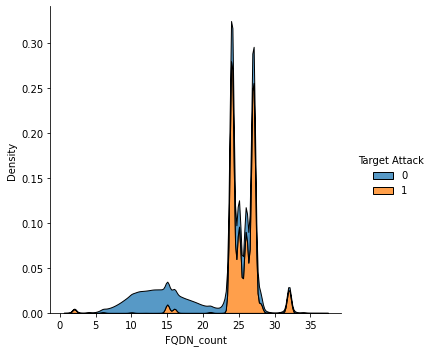

count    268074.000000
mean          6.059021
std           3.899505
min           0.000000
25%           3.000000
50%           7.000000
75%          10.000000
max          23.000000
Name: subdomain_length, dtype: float64


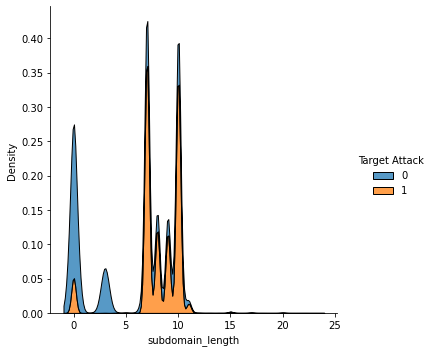

count    268074.000000
mean          0.845420
std           4.941929
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          32.000000
Name: upper, dtype: float64


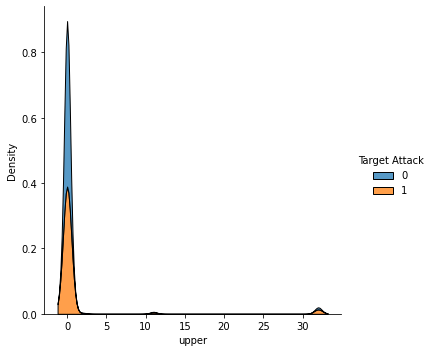

count    268074.000000
mean         10.410014
std           3.207725
min           0.000000
25%          10.000000
50%          10.000000
75%          10.000000
max          34.000000
Name: lower, dtype: float64


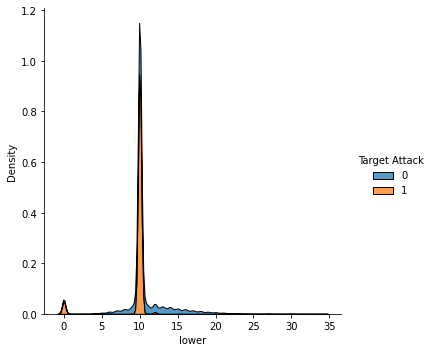

count    268074.000000
mean          6.497586
std           4.499866
min           0.000000
25%           0.000000
50%           8.000000
75%          10.000000
max          12.000000
Name: numeric, dtype: float64


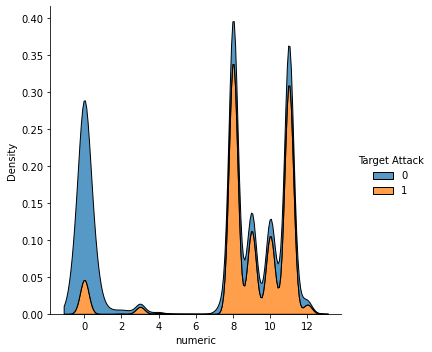

count    268074.000000
mean          2.485735
std           0.407709
min           0.219195
25%           2.054029
50%           2.570417
75%           2.767195
max           4.216847
Name: entropy, dtype: float64


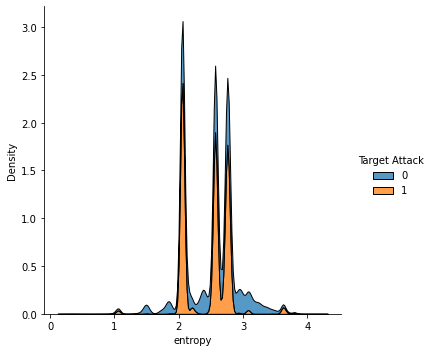

count    268074.000000
mean          4.533577
std           2.187683
min           0.000000
25%           2.000000
50%           6.000000
75%           6.000000
max           7.000000
Name: special, dtype: float64


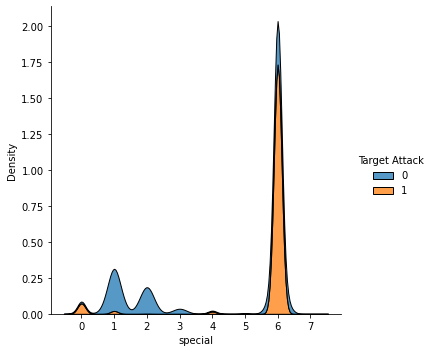

count    268074.000000
mean          4.788823
std           1.803256
min           1.000000
25%           3.000000
50%           6.000000
75%           6.000000
max           7.000000
Name: labels, dtype: float64


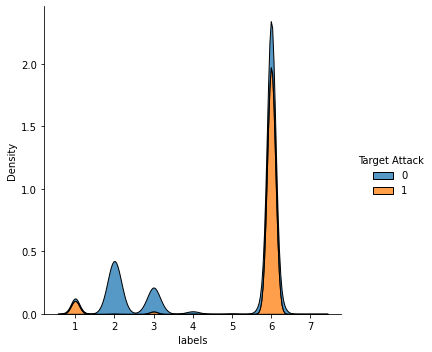

count    268074.000000
mean          8.252233
std           4.415355
min           2.000000
25%           7.000000
50%           7.000000
75%           7.000000
max          32.000000
Name: labels_max, dtype: float64


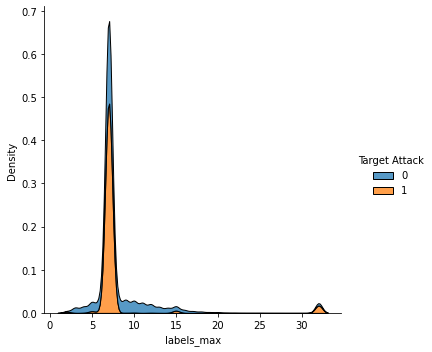

count    268074.000000
mean          4.802239
std           4.573066
min           2.000000
25%           3.166667
50%           3.666667
75%           4.000000
max          32.000000
Name: labels_average, dtype: float64


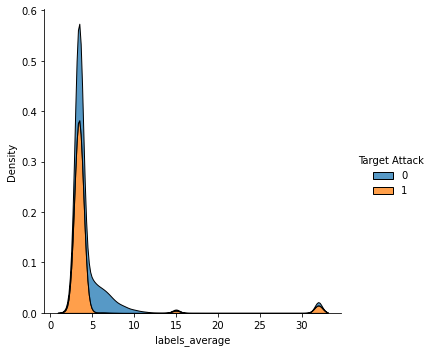

count    268074.000000
mean         12.576714
std           4.177828
min           2.000000
25%          11.000000
50%          12.000000
75%          14.000000
max          33.000000
Name: len, dtype: float64


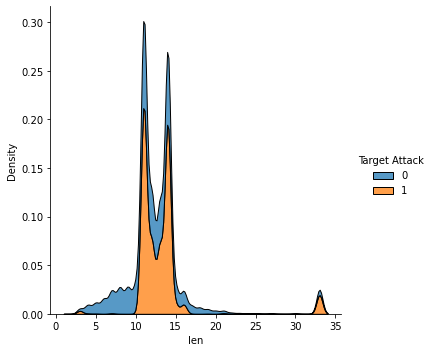

count    268074.000000
mean          0.753497
std           0.430975
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: subdomain, dtype: float64


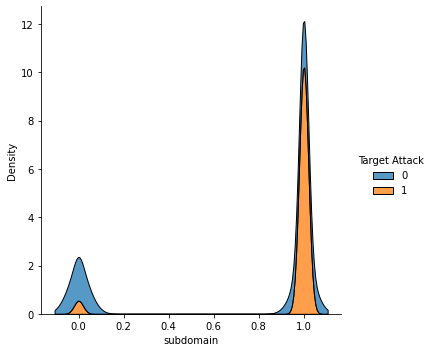

In [31]:
# plot the distribution (Density plot) of each numeric feature 
plot_feturesDistributions(static_dataset,statisticsTable,numeric_features_names,target_name)

<h3 style="color:rgb(92, 11, 10)"> 3. validate if your dataset is imbalanced and if you have any type of data skewed pattern.</h3>

Target Name : Target Attack
value count
1    147179
0    120895
Name: Target Attack, dtype: int64


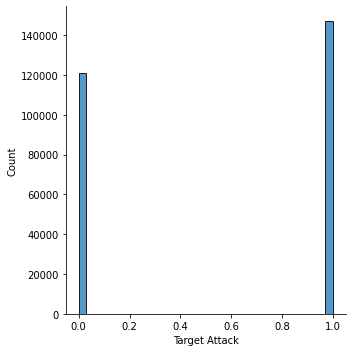

In [32]:
checkBalance(static_dataset,target_name)

-------------------------------

## 2.Feature engineering and data cleaning

<h3 style="color:rgb(92, 11, 10)">  1. Analyze the data inside the (static_dataset.csv) file </h3>

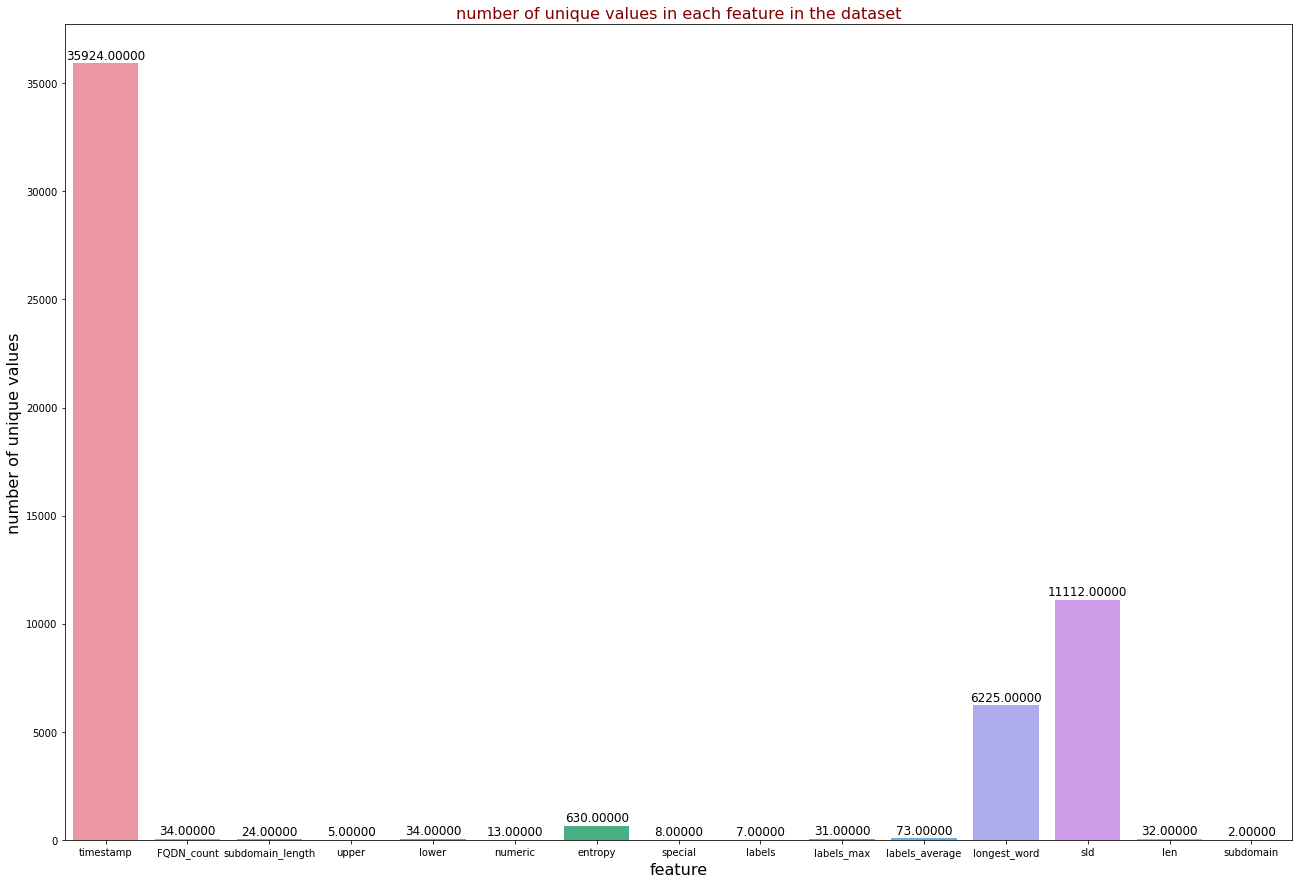

In [33]:
# check the number of unique values in each feature 
represent_features(static_dataset,features_names)

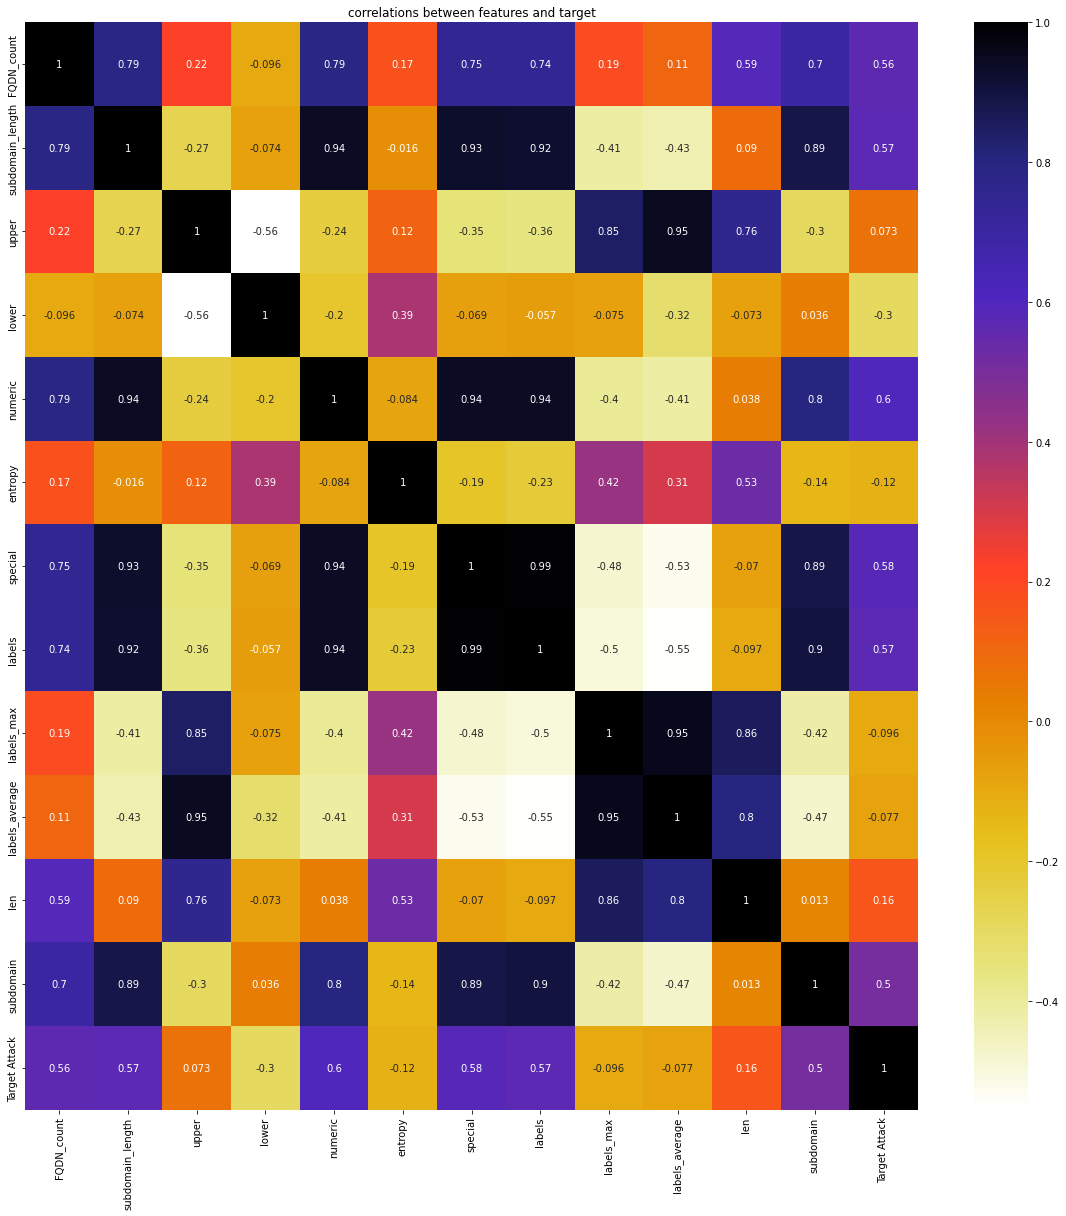

In [34]:
# check the correlation
checkCorrelations(static_dataset)

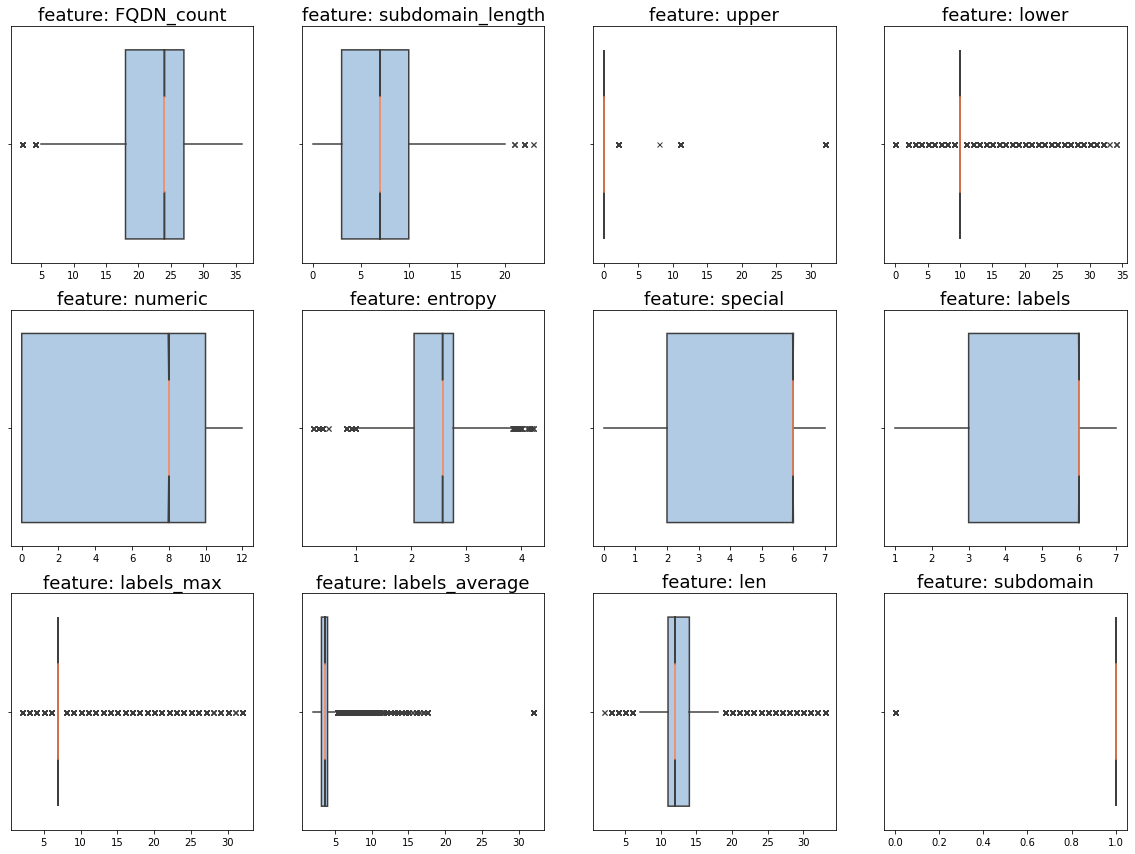

In [35]:
# plot the boxplot for the continuous features 
boxPlot_continueusFeatures(static_dataset,numeric_features_names)

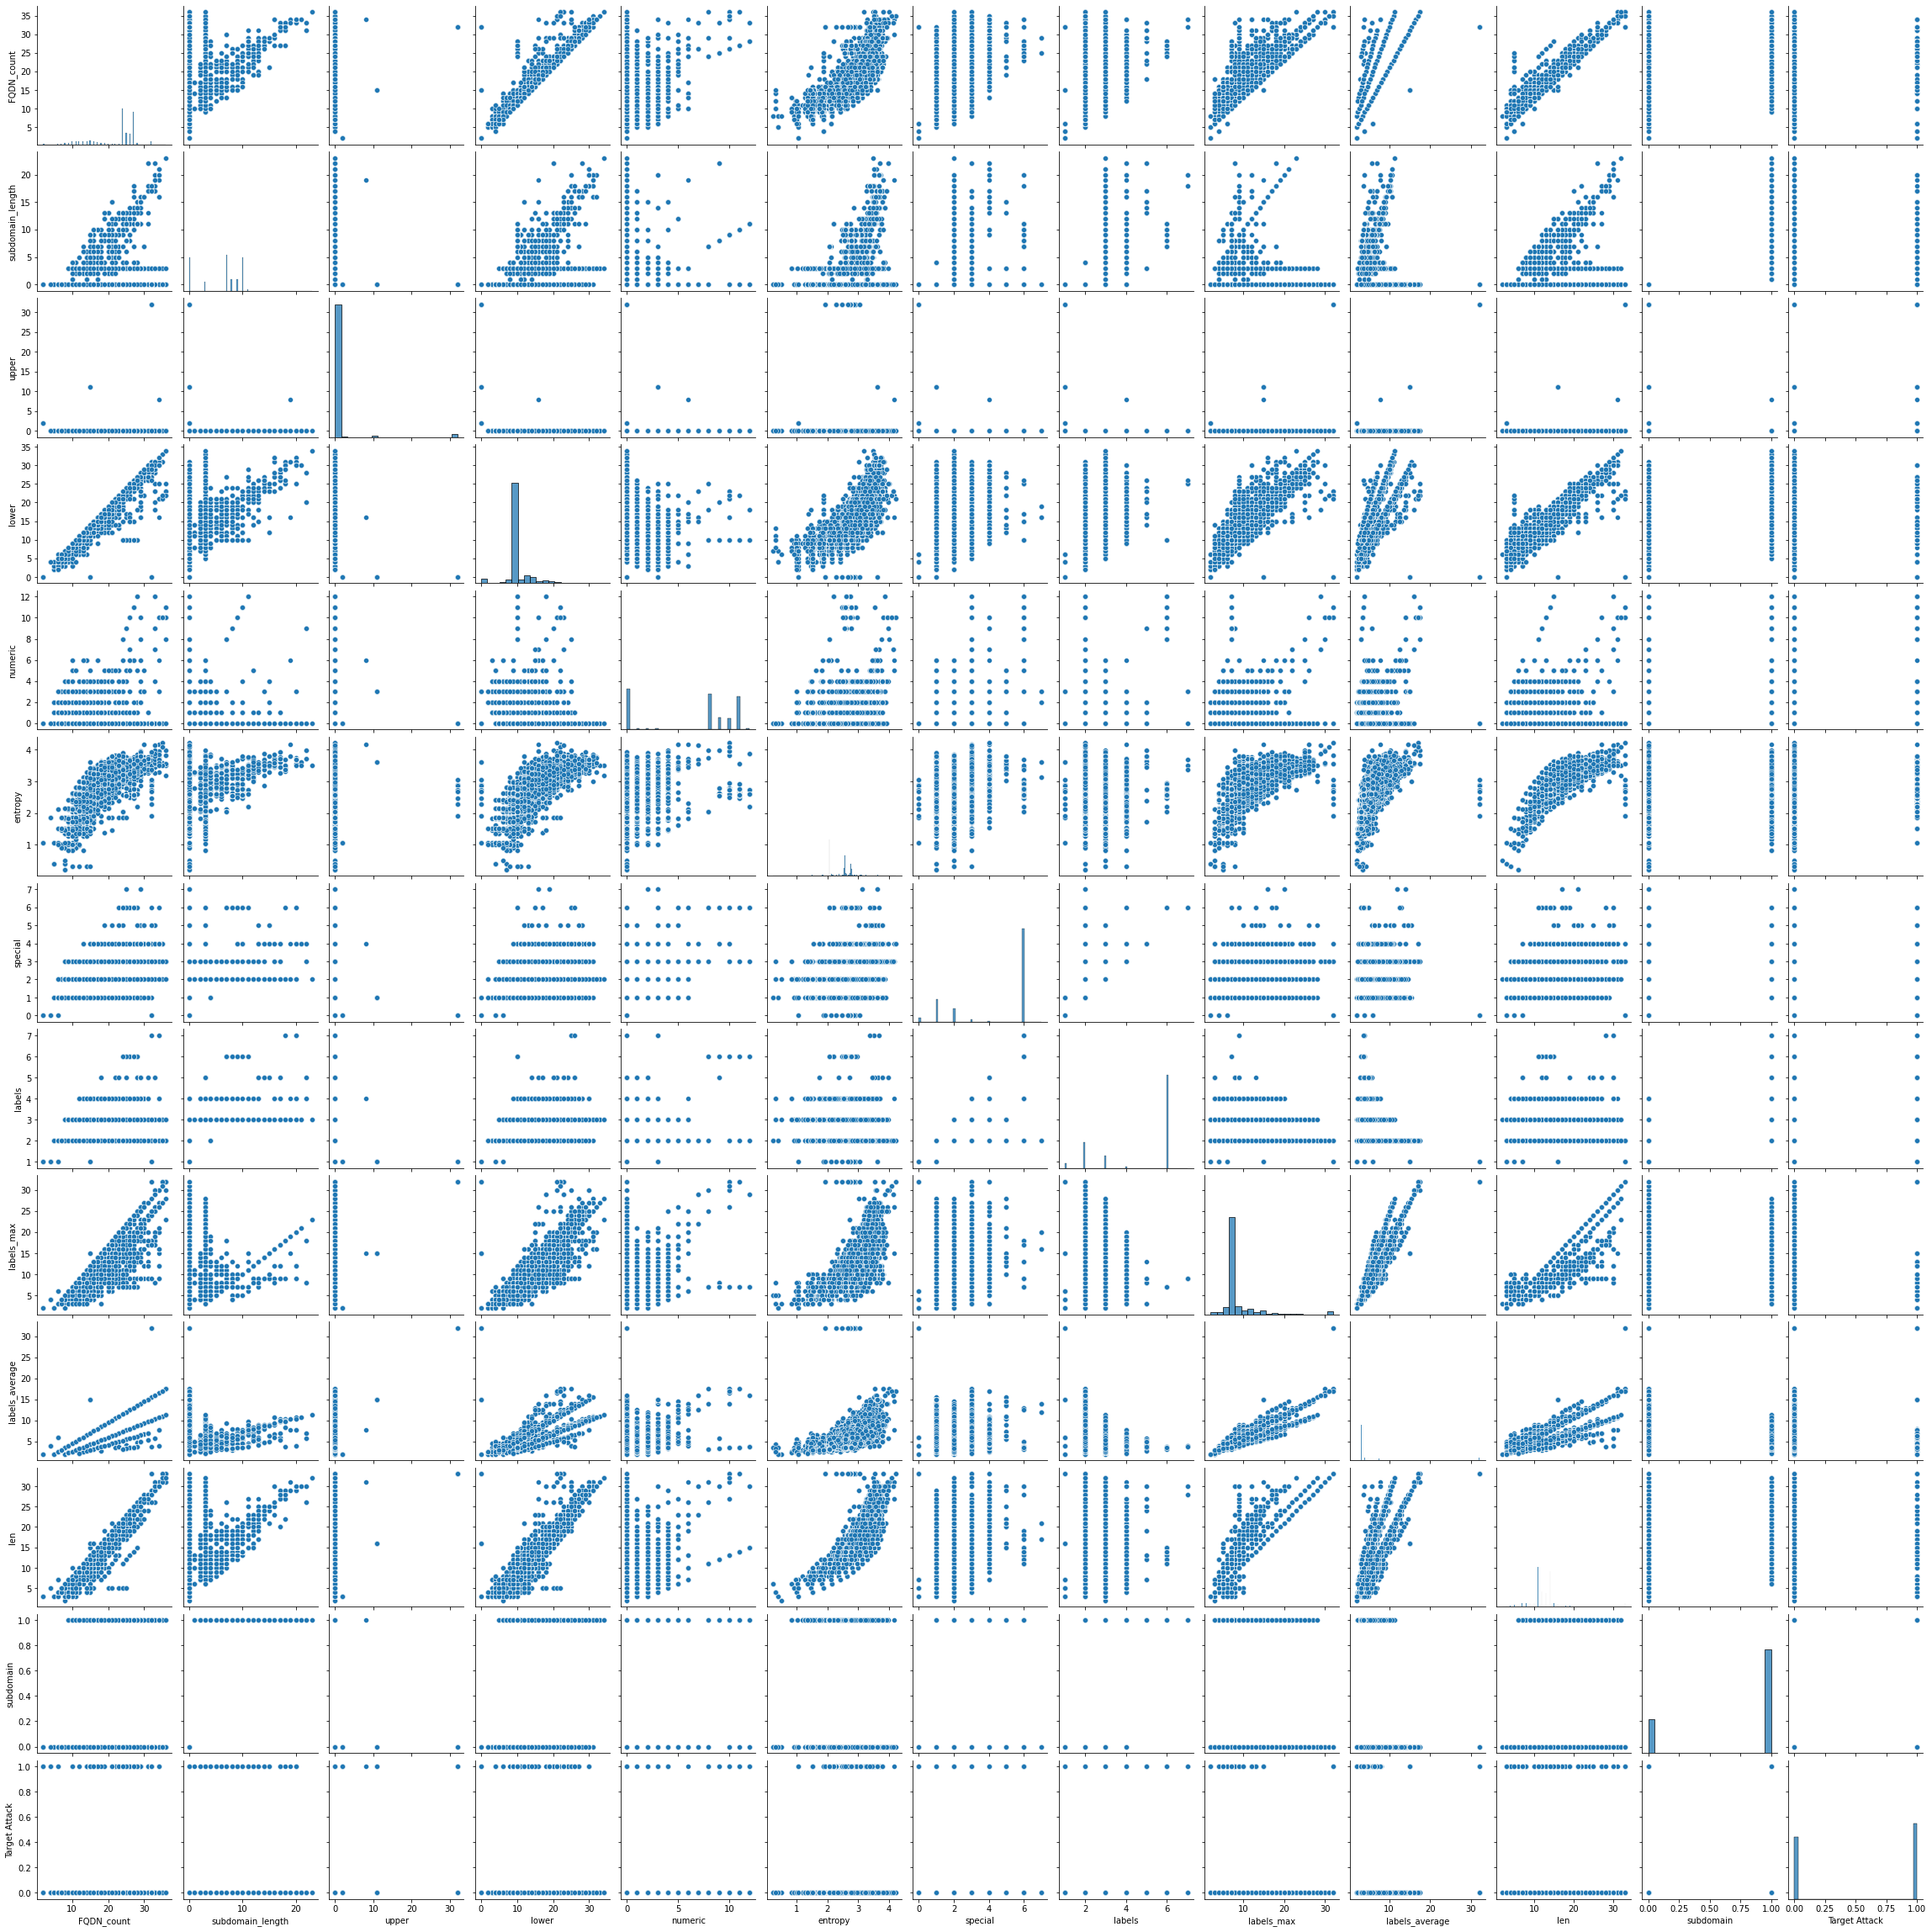

In [36]:
plot_distributions_and_correlations(static_dataset)

<h3 style="color:rgb(92, 11, 10)">  3. Check for missing values and categorical values.</h3>

In [37]:
# check the missing values 
checkNull(features).style.highlight_max(color = 'lightgreen', axis = 0)

,mising values
timestamp,0
FQDN_count,0
subdomain_length,0
upper,0
lower,0
numeric,0
entropy,0
special,0
labels,0
labels_max,0


In [38]:
# drop the null values 
static_dataset= static_dataset.dropna()

In [39]:
# check missing again 
checkNull(static_dataset)

,mising values
timestamp,0
FQDN_count,0
subdomain_length,0
upper,0
lower,0
numeric,0
entropy,0
special,0
labels,0
labels_max,0


<h3 style="color:rgb(92, 11, 10)">  2. transform the variables that contain string values, so that all of them can be used in the model. </h3>

In [40]:
static_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268066 entries, 0 to 268073
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   timestamp         268066 non-null  object 
 1   FQDN_count        268066 non-null  int64  
 2   subdomain_length  268066 non-null  int64  
 3   upper             268066 non-null  int64  
 4   lower             268066 non-null  int64  
 5   numeric           268066 non-null  int64  
 6   entropy           268066 non-null  float64
 7   special           268066 non-null  int64  
 8   labels            268066 non-null  int64  
 9   labels_max        268066 non-null  int64  
 10  labels_average    268066 non-null  float64
 11  longest_word      268066 non-null  object 
 12  sld               268066 non-null  object 
 13  len               268066 non-null  int64  
 14  subdomain         268066 non-null  int64  
 15  Target Attack     268066 non-null  int64  
dtypes: float64(2), int64

The feature "longest_word" represents the longest meaningful word over the domain length. I thought about different ways to represent the longest word without dealing with it as garbage data. So, I have changed the longest word with the length to the word itself.  

In [41]:
new_column = static_dataset['longest_word'].apply(lambda x: len(x))

In [42]:
static_dataset['longest_word'] = new_column

In [43]:
static_dataset['longest_word'].value_counts()

1     193739
4      15865
5      14069
3      13861
6       8721
2       7790
7       6494
8       3548
9       2296
10      1033
11       427
12       117
13        71
14        24
15         6
16         5
Name: longest_word, dtype: int64

#### plot the distribution of the "length of the longest word over the domain length" 

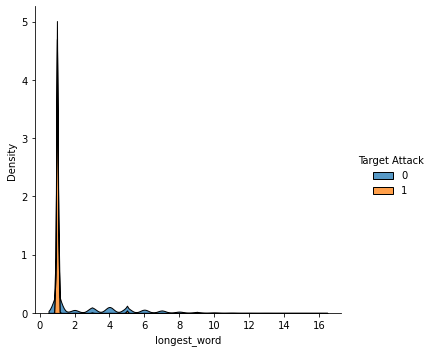

In [44]:
sns.displot(x ='longest_word',hue=target_name,data = static_dataset, kind="kde", multiple="stack")
plt.show()

- the "sld" feature represent the second level domain. 
* so i decided also to change it with the length of the second level domain 

In [45]:
new_column2 = static_dataset['sld'].apply(lambda x: len(x))
static_dataset['sld'] = new_column2

In [46]:
static_dataset['sld'].value_counts()

3     185306
7       7992
9       7901
8       7678
6       7037
10      6939
5       6738
32      6357
11      5971
12      4995
15      4103
4       3839
13      3553
14      2923
16      1714
2       1543
17      1099
18       813
19       533
20       462
21       175
22       126
23        65
25        62
24        58
26        29
27        21
30        13
29         9
28         6
31         4
1          2
Name: sld, dtype: int64

#### plot the distribution of the "length of second level domain" 

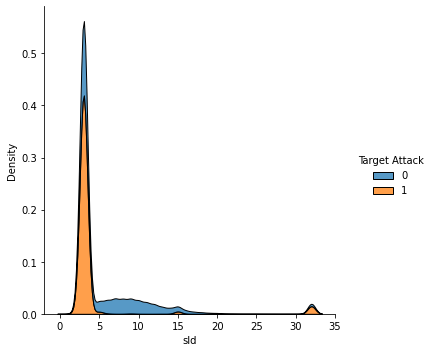

In [47]:
sns.displot(x ='sld',hue=target_name,data = static_dataset, kind="kde", multiple="stack")
plt.show()

In [48]:
static_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268066 entries, 0 to 268073
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   timestamp         268066 non-null  object 
 1   FQDN_count        268066 non-null  int64  
 2   subdomain_length  268066 non-null  int64  
 3   upper             268066 non-null  int64  
 4   lower             268066 non-null  int64  
 5   numeric           268066 non-null  int64  
 6   entropy           268066 non-null  float64
 7   special           268066 non-null  int64  
 8   labels            268066 non-null  int64  
 9   labels_max        268066 non-null  int64  
 10  labels_average    268066 non-null  float64
 11  longest_word      268066 non-null  int64  
 12  sld               268066 non-null  int64  
 13  len               268066 non-null  int64  
 14  subdomain         268066 non-null  int64  
 15  Target Attack     268066 non-null  int64  
dtypes: float64(2), int64

------------------------------------------------

## 3.Feature Filtering/Selection

I decided to drop the timestamp column because all the other features in the dataset are stateless. So, none of the other features will be correlated with the timestamp, which makes me consider that it would have no effect on the classification decision.  
 

In [49]:
# split the static_dataset into train, test to perform feature selection 

# get features number and names 
X=static_dataset.drop(labels = ["Target Attack", "timestamp"], axis=1) 
# get label 
y=static_dataset["Target Attack"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True,stratify=y)

In [50]:
print(f"the shape of the training set : {X_train.shape}")
print(f"the shape of the testing  set : {X_test.shape}")

the shape of the training set : (214452, 14)
the shape of the testing  set : (53614, 14)


In [51]:
y_train.value_counts()

1    117743
0     96709
Name: Target Attack, dtype: int64

In [52]:
y_test.value_counts()

1    29436
0    24178
Name: Target Attack, dtype: int64

<h3 style="color:rgb(92, 11, 10)"> 1. Use at least two different statistical techniques to evaluate which features are the best to train your model</h3>

* to choce the best feature set i implemented two approaches : 
    - first approach  : using only statistical method without training any models, like check feature importance and choose from it manually. 
    - second approach : choose specific statistical test in a loop and train a model each time then evaluate the f1-score of this model with those features. 
    

#### use the Information Gain statistical method to show feature importance 

In [59]:
importance = mutual_info_classif(X,y)

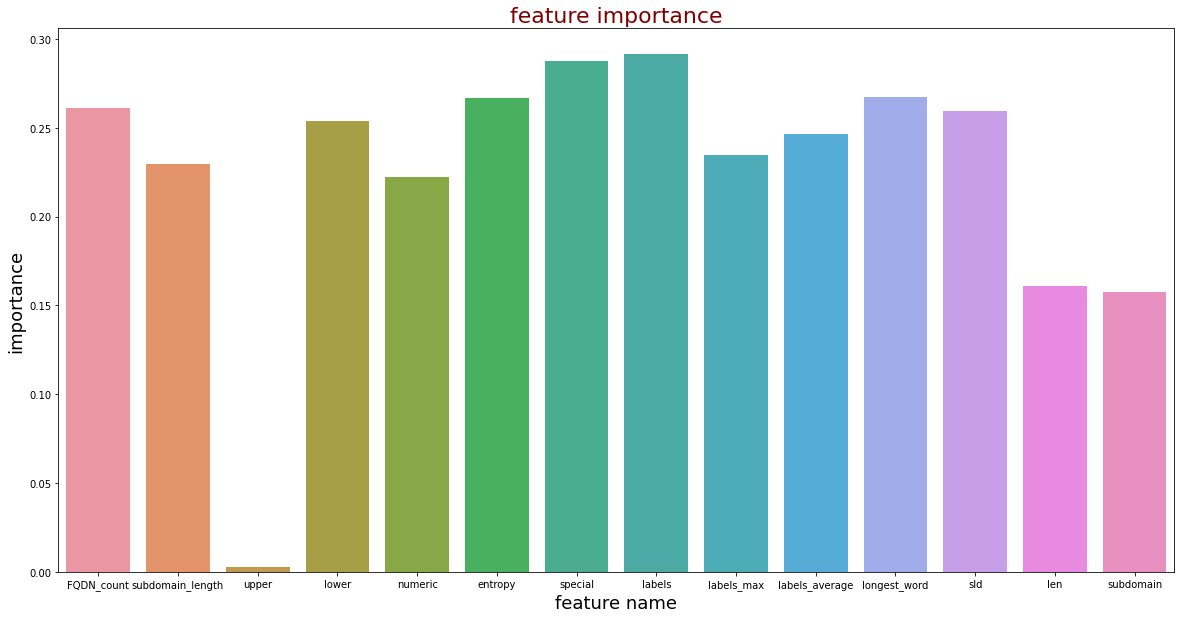

In [72]:
plt.figure(figsize=(20,10))
plt.xlabel("feature name", fontsize=18)
plt.ylabel("importance", fontsize=18)
plt.title("feature importance",fontsize=22,color="maroon")
plots=sns.barplot(x = list(X.columns), y= importance)

#### again check the correlation between features after process the data 

In [91]:
cor_matrix = static_dataset.corr().abs()
cor_matrix

,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Target Attack
FQDN_count,1.000000,0.788602,0.223166,0.095910,0.793066,0.167753,0.748334,0.739768,0.186968,0.109442,0.573420,0.112838,0.588822,0.698675,0.563542
subdomain_length,0.788602,1.000000,0.265795,0.073829,0.944546,0.015819,0.929072,0.923206,0.410859,0.431766,0.662179,0.646051,0.090422,0.888718,0.572035
upper,0.223166,0.265795,1.000000,0.555151,0.236170,0.115455,0.347080,0.359446,0.847048,0.946883,0.090042,0.771939,0.759109,0.299096,0.072891
lower,0.095910,0.073829,0.555151,1.000000,0.197690,0.385450,0.068656,0.057234,0.074639,0.318587,0.607415,0.003065,0.072921,0.036057,0.295618
numeric,0.793066,0.944546,0.236170,0.197690,1.000000,0.084333,0.941948,0.940189,0.395483,0.411212,0.751193,0.646801,0.037690,0.801605,0.599234
entropy,0.167753,0.015819,0.115455,0.385450,0.084333,1.000000,0.192378,0.226744,0.418581,0.307462,0.368292,0.414686,0.526276,0.138288,0.119091
special,0.748334,0.929072,0.347080,0.068656,0.941948,0.192378,1.000000,0.991308,0.477736,0.525872,0.715061,0.718469,0.070265,0.890511,0.582088
labels,0.739768,0.923206,0.359446,0.057234,0.940189,0.226744,0.991308,1.000000,0.497838,0.545632,0.702566,0.734596,0.096782,0.898862,0.569396
labels_max,0.186968,0.410859,0.847048,0.074639,0.395483,0.418581,0.477736,0.497838,1.000000,0.954822,0.262920,0.950043,0.856086,0.420548,0.096373
labels_average,0.109442,0.431766,0.946883,0.318587,0.411212,0.307462,0.525872,0.545632,0.954822,1.000000,0.162196,0.923819,0.802362,0.473734,0.077173


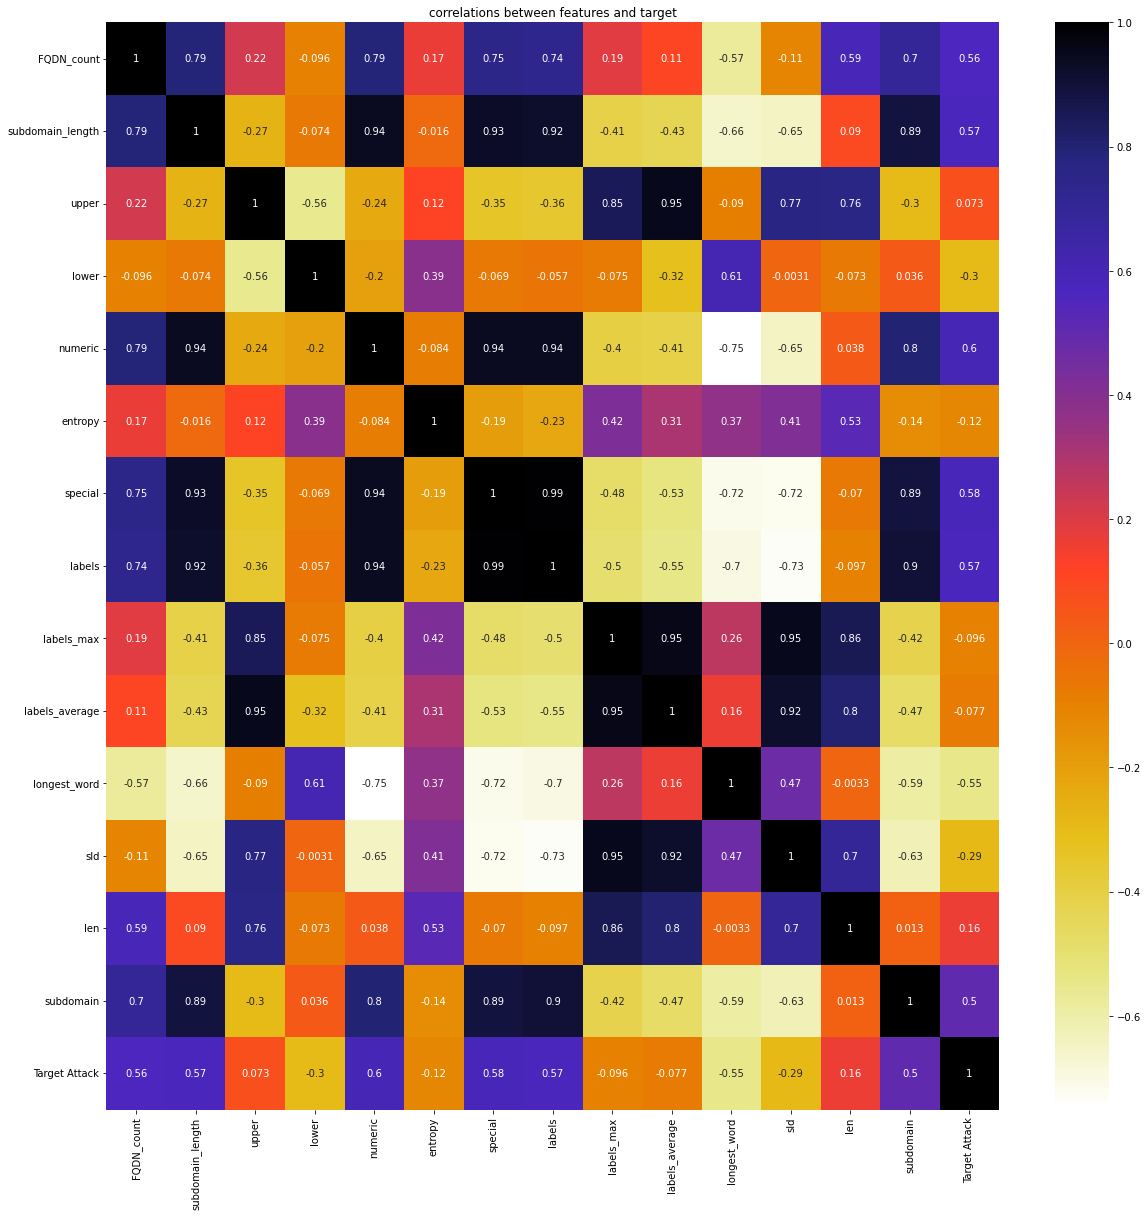

In [92]:
# check the correlation
checkCorrelations(static_dataset)

#### second approach : choose the features based on training a model 

In [73]:
# use Logistic regression model to be trained with the selected data 
LR_clf = LogisticRegression(random_state=0,max_iter=1000)


# try Mutual information statistical method to select the best features 
LR_MutualInfo_f1_score ,dct4,MutualInfo_selected_features_names= select_get_f1_score(LR_clf,mutual_info_classif,X_train, y_train.values.ravel(), X_test, y_test.values.ravel(),"Mutual information","LR")
LR_ANOVA_f1_score,dct5  ,ANOVA_selected_features_names         = select_get_f1_score(LR_clf,f_classif,X_train, y_train.values.ravel(), X_test, y_test.values.ravel(),"ANOVA F-value","LR")
LR_chi_square_f1_score ,dct6,chi_square_selected_features_names= select_get_f1_score(LR_clf,chi2,X_train, y_train.values.ravel(), X_test, y_test.values.ravel(),"chi square","LR")

with "Mutual information" filter method
{1: 0.8405695895069224, 2: 0.8413552070622619, 3: 0.8412284797638234, 4: 0.8410355091854835, 5: 0.8514378182573968, 6: 0.851336707883682, 7: 0.858017117769664, 8: 0.860325646504089, 9: 0.8602495911361259, 10: 0.8602030142758225, 11: 0.8616736721436761, 12: 0.8616736721436761, 13: 0.8616736721436761, 14: 0.8616863361796564}
Maximum f1_score of LR model         :0.8616863361796564 %
Best number of features for LR model :14
Best features for LR model           :['FQDN_count', 'subdomain_length', 'upper', 'lower', 'numeric', 'entropy', 'special', 'labels', 'labels_max', 'labels_average', 'longest_word', 'sld', 'len', 'subdomain']
with "ANOVA F-value" filter method
{1: 0.8402799921043441, 2: 0.8402672335256605, 3: 0.8402799921043441, 4: 0.8404434401492288, 5: 0.8381047441888602, 6: 0.8496007821411112, 7: 0.8498525641975491, 8: 0.8618722803716335, 9: 0.8618469408755476, 10: 0.8618469408755476, 11: 0.8618469408755476, 12: 0.8617116653683916, 13: 0.86167

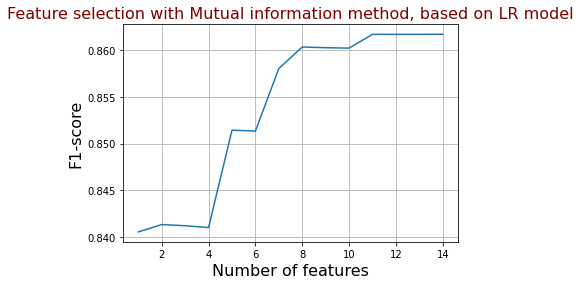

Maximum f1_score of LR model         : 0.8616863361796564
Best number of features for LR model : 14


In [74]:
line_plot(dct4,"Mutual information","LR",Title="Feature selection with Mutual information method, based on LR model",x_label="Number of features",y_label="F1-score")


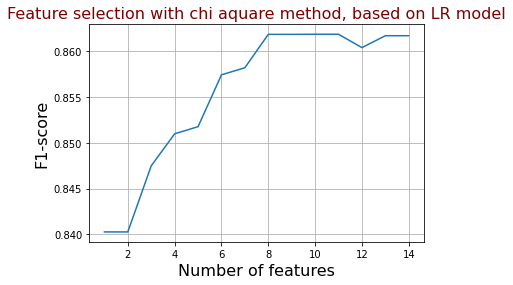

Maximum f1_score of LR model         : 0.8618469408755476
Best number of features for LR model : 10


In [75]:
line_plot(dct6,"chi square","LR",Title="Feature selection with chi aquare method, based on LR model",x_label="Number of features",y_label="F1-score")

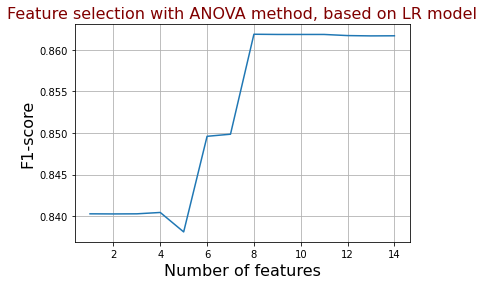

Maximum f1_score of LR model         : 0.8618722803716335
Best number of features for LR model : 8


In [81]:
line_plot(dct5,"ANOVA","LR",Title="Feature selection with ANOVA method, based on LR model",x_label="Number of features",y_label="F1-score")

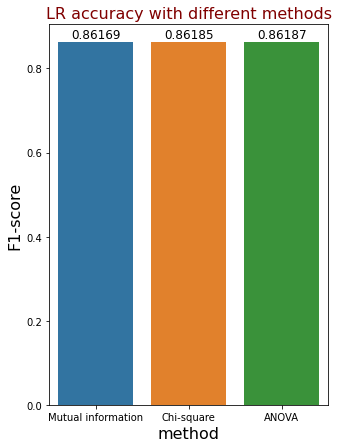

In [82]:
barplot_value(x_axis=["Mutual information","Chi-square","ANOVA"],y_axis=[LR_MutualInfo_f1_score ,LR_chi_square_f1_score,LR_ANOVA_f1_score],title = "LR accuracy with different methods",x_label = "method",y_label = "F1-score",figure_size=(5,7))

### Perform Dimensionality Reduction using PCA and tune the best number of components

In [78]:
n_components = [1,2,3,4,5,6,7,8,9,10]
LR_f1_scores = []
LR_clf = LogisticRegression(random_state=0,max_iter=1000)

for c in n_components:
    LR_f1_Score = perform_PCA_with_LogisticRegression(X,y,c,"Logistic REgression",LR_clf)
    LR_f1_scores.append(LR_f1_Score)

the F1-score of Logistic REgression  algorithm  after applaying PCA with 1 components:(0.8079012203380063)
the F1-score of Logistic REgression  algorithm  after applaying PCA with 2 components:(0.8522808480228681)
the F1-score of Logistic REgression  algorithm  after applaying PCA with 3 components:(0.8558252643129347)
the F1-score of Logistic REgression  algorithm  after applaying PCA with 4 components:(0.8558252643129347)
the F1-score of Logistic REgression  algorithm  after applaying PCA with 5 components:(0.8539987508550695)
the F1-score of Logistic REgression  algorithm  after applaying PCA with 6 components:(0.8538844695561668)
the F1-score of Logistic REgression  algorithm  after applaying PCA with 7 components:(0.8611356281259194)
the F1-score of Logistic REgression  algorithm  after applaying PCA with 8 components:(0.858951095375083)
the F1-score of Logistic REgression  algorithm  after applaying PCA with 9 components:(0.858951095375083)
the F1-score of Logistic REgression  al

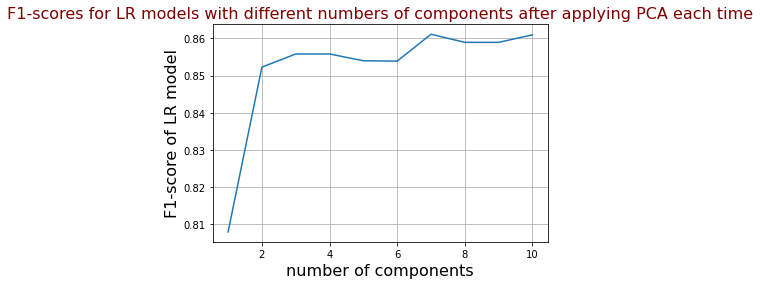

In [79]:
line_plot_2_lists(x=n_components,y=LR_f1_scores,title="F1-scores for LR models with different numbers of components after applying PCA each time",x_label="number of components",y_label="F1-score of LR model")

In [80]:
max_f1_score = find_best_n_component(LR_f1_scores,n_components,"LR")

the best value of n_components, based on f1-score,for LR classifier 
best F1-score is :( 0.8611 )%
best number of component is : 7


<h3 style="color:rgb(92, 11, 10)"> 2. give a final list of those you will use </h3>

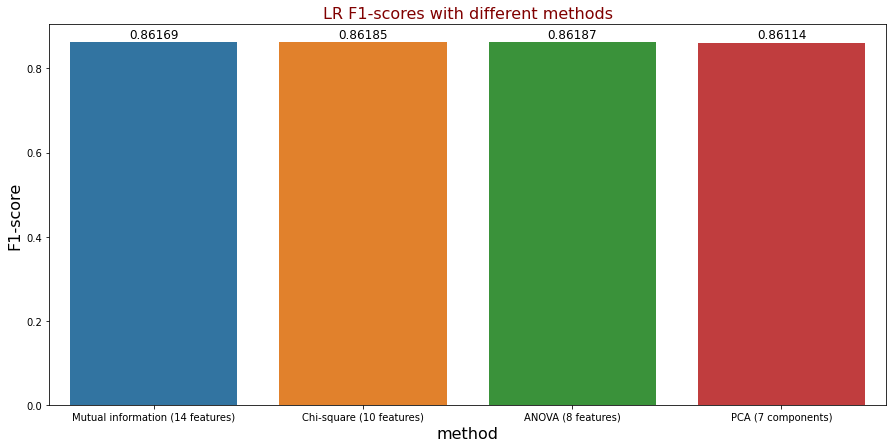

In [83]:
barplot_value(x_axis=["Mutual information (14 features)","Chi-square (10 features)","ANOVA (8 features)","PCA (7 components)"],y_axis=[LR_MutualInfo_f1_score ,LR_chi_square_f1_score,LR_ANOVA_f1_score,max_f1_score],title = "LR F1-scores with different methods",x_label = "method",y_label = "F1-score",figure_size=(15,7) )

#### selected features 

In [54]:
ANOVA_selected_features_names 

['FQDN_count',
 'subdomain_length',
 'lower',
 'numeric',
 'special',
 'labels',
 'longest_word',
 'subdomain']

In [55]:
# before feature selection
X_train.head()

,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain
2458,24,7,0,10,8,2.054029,6,6,7,3.166667,1,3,11,1
233836,20,3,0,18,0,3.327820,2,3,12,6.000000,8,12,16,1
224215,26,9,0,10,10,2.742338,6,6,7,3.500000,1,3,13,1
146599,25,8,0,10,9,2.556642,6,6,7,3.333333,1,3,12,1
49129,24,7,0,10,8,2.054029,6,6,7,3.166667,1,3,11,1


In [56]:
selected_X_train = X_train[ANOVA_selected_features_names]
selected_X_test  = X_test[ANOVA_selected_features_names]

In [57]:
# after feature selection => it expected to be 8 features 
selected_X_train.head()

,FQDN_count,subdomain_length,lower,numeric,special,labels,longest_word,subdomain
2458,24,7,10,8,6,6,1,1
233836,20,3,18,0,2,3,8,1
224215,26,9,10,10,6,6,1,1
146599,25,8,10,9,6,6,1,1
49129,24,7,10,8,6,6,1,1


the best number of features based on the F1-score of the logistic regression is 8 features.  
using ANOVA test. 

---------------------------

## 4.Model Training

<h3 style="color:rgb(92, 11, 10)"> 1. Split the data using a method you find suitable and justify it.</h3>

In [58]:
# we first devided the data into training and testing to choose the best set of features 
# for model traning i will use cross validation technique.  so i will use only selected_x_train 

<h3 style="color:rgb(92, 11, 10)"> 2. Normalize your data </h3>

In [59]:
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(selected_X_train)
X_test_normalized = scaler.transform(selected_X_test)

### save the scaler to be used in the Dynamic model 

In [72]:
pickle.dump(scaler, open('Scaler.pkl', 'wb'))

In [60]:
# after normalization
pd.DataFrame(X_train_normalized).describe()

,0,1,2,3,4,5,6,7
count,214452.000000,214452.000000,214452.000000,214452.000000,214452.000000,214452.000000,214452.000000,214452.000000
mean,0.596703,0.263483,0.306203,0.541362,0.647608,0.631482,0.069955,0.753716
std,0.176495,0.169531,0.094307,0.375066,0.312543,0.300480,0.132852,0.430847
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.470588,0.130435,0.294118,0.000000,0.285714,0.333333,0.000000,1.000000
50%,0.647059,0.304348,0.294118,0.666667,0.857143,0.833333,0.000000,1.000000
75%,0.735294,0.434783,0.294118,0.833333,0.857143,0.833333,0.066667,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### plot the distribution of the features after normalization

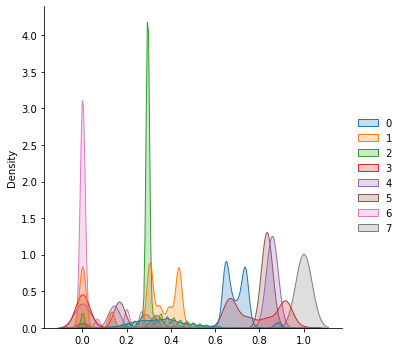

In [61]:
# plot the distribution of the features 
sns.displot(data = pd.DataFrame(X_train_normalized), kind="kde",fill=True)
plt.show()

<h3 style="color:rgb(92, 11, 10)"> 3.1 train the selected model 1.</h3>

In [97]:
LR_clf = LogisticRegression(random_state=0,max_iter=1000)

              precision    recall  f1-score   support

           0       0.98      0.62      0.76     19342
           1       0.76      0.99      0.86     23549

    accuracy                           0.82     42891
   macro avg       0.87      0.80      0.81     42891
weighted avg       0.86      0.82      0.81     42891



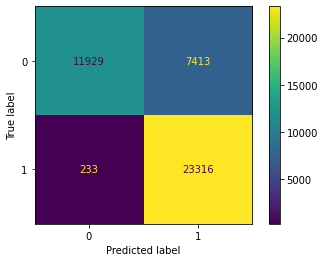

              precision    recall  f1-score   support

           0       0.98      0.62      0.76     19342
           1       0.76      0.99      0.86     23549

    accuracy                           0.82     42891
   macro avg       0.87      0.81      0.81     42891
weighted avg       0.86      0.82      0.82     42891



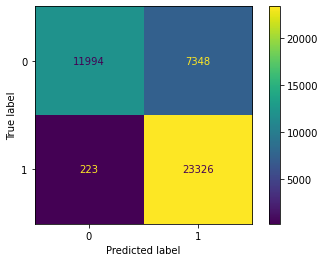

              precision    recall  f1-score   support

           0       0.98      0.61      0.75     19341
           1       0.76      0.99      0.86     23549

    accuracy                           0.82     42890
   macro avg       0.87      0.80      0.81     42890
weighted avg       0.86      0.82      0.81     42890



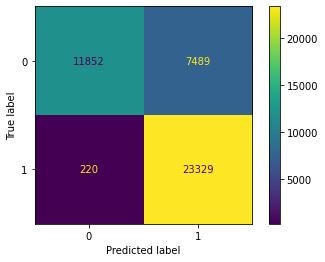

              precision    recall  f1-score   support

           0       0.98      0.62      0.76     19342
           1       0.76      0.99      0.86     23548

    accuracy                           0.82     42890
   macro avg       0.87      0.80      0.81     42890
weighted avg       0.86      0.82      0.81     42890



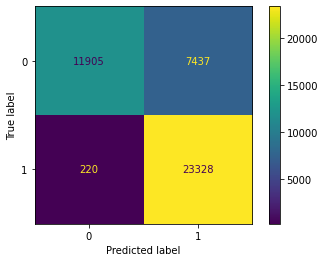

              precision    recall  f1-score   support

           0       0.98      0.62      0.76     19342
           1       0.76      0.99      0.86     23548

    accuracy                           0.82     42890
   macro avg       0.87      0.81      0.81     42890
weighted avg       0.86      0.82      0.82     42890



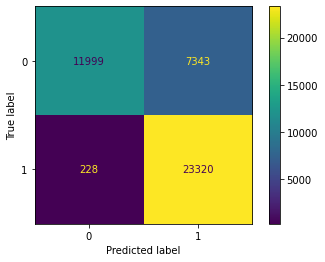

the f1-score in all iterations       : [0.85913261 0.8603729  0.85820443 0.85902086 0.860342  ]
the mean of f1-scores                : 0.8594145602253551
the std  of f1-scores                : 0.0008339642860405091


In [98]:
LR_mean,LR_std , LR_Score_Lst = apply_CV_F1(LR_clf,X_train_normalized,y_train.values.ravel())

<h3 style="color:rgb(92, 11, 10)"> 3.2 train the selected model 2. </h3>

In [99]:
xgb_CLF = xgb.XGBClassifier(objective="binary:logistic", random_state=0)

              precision    recall  f1-score   support

           0       1.00      0.61      0.76     19342
           1       0.76      1.00      0.86     23549

    accuracy                           0.83     42891
   macro avg       0.88      0.81      0.81     42891
weighted avg       0.87      0.83      0.82     42891



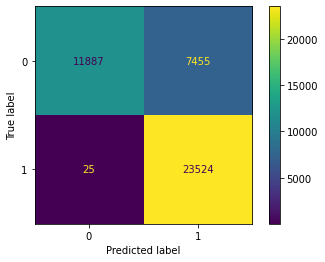

              precision    recall  f1-score   support

           0       1.00      0.62      0.76     19342
           1       0.76      1.00      0.86     23549

    accuracy                           0.83     42891
   macro avg       0.88      0.81      0.81     42891
weighted avg       0.87      0.83      0.82     42891



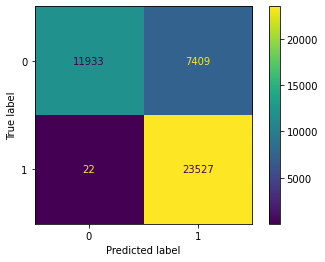

              precision    recall  f1-score   support

           0       1.00      0.61      0.76     19341
           1       0.76      1.00      0.86     23549

    accuracy                           0.82     42890
   macro avg       0.88      0.80      0.81     42890
weighted avg       0.87      0.82      0.81     42890



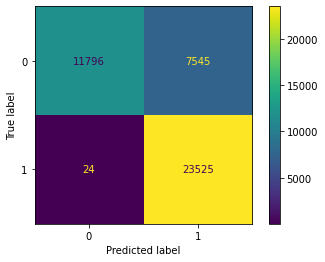

              precision    recall  f1-score   support

           0       1.00      0.61      0.76     19342
           1       0.76      1.00      0.86     23548

    accuracy                           0.82     42890
   macro avg       0.88      0.81      0.81     42890
weighted avg       0.87      0.82      0.82     42890



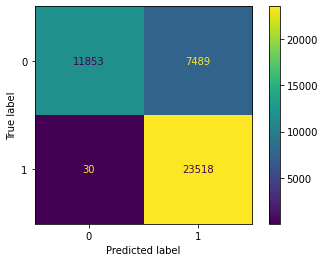

              precision    recall  f1-score   support

           0       1.00      0.62      0.76     19342
           1       0.76      1.00      0.86     23548

    accuracy                           0.83     42890
   macro avg       0.88      0.81      0.81     42890
weighted avg       0.87      0.83      0.82     42890



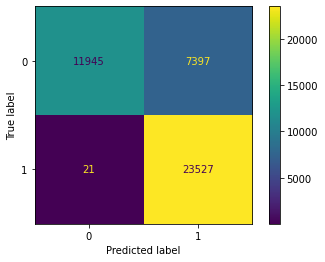

the f1-score in all iterations       : [0.86282277 0.86361384 0.86142185 0.86217579 0.86381994]
the mean of f1-scores                : 0.8627708376518856
the std  of f1-scores                : 0.0008930652522300761


In [100]:
xgb_mean,xgb_std , xgb_Score_Lst = apply_CV_F1(xgb_CLF,X_train_normalized,y_train.values.ravel())

<h3 style="color:rgb(92, 11, 10)"> 4. analyze which metrics and performance evaluation will be the best for your modeles.</h3> 

I used f1-score as an evaluation metric Since  the f1-score sums up between the precision and the recall. I did not choose accuracy because I care about the positive class which means that accuracy is not the best choice in this case because I may get a high accuracy, but the model fails to classify the positive instances. 

<h3 style="color:rgb(92, 11, 10)"> 5. provide a comparison between the metrics of the two models.</h3>

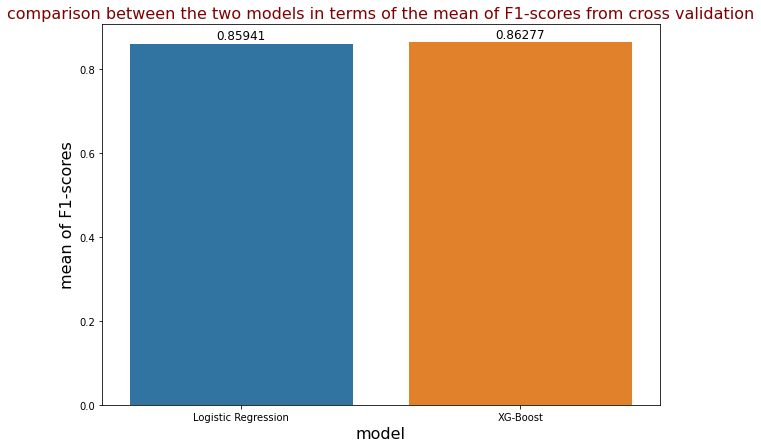

In [101]:
barplot_value(x_axis=["Logistic Regression","XG-Boost"],y_axis=[LR_mean,xgb_mean],title = "comparison between the two models in terms of the mean of F1-scores from cross validation",x_label = "model",y_label = "mean of F1-scores",figure_size=(10,7) )

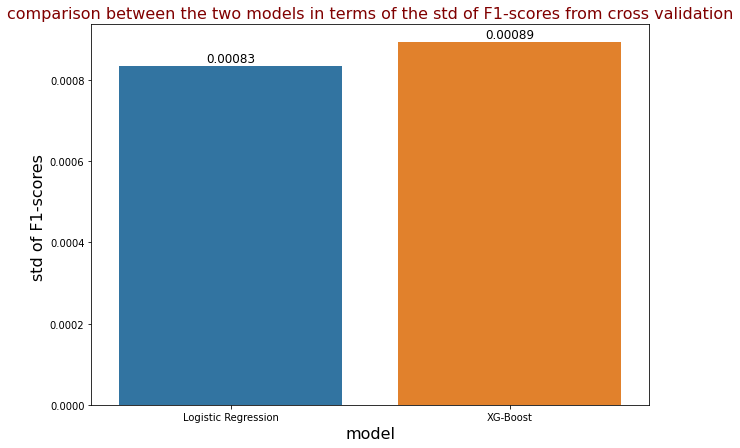

In [102]:
barplot_value(x_axis=["Logistic Regression","XG-Boost"],y_axis=[LR_std,xgb_std],title = "comparison between the two models in terms of the std of F1-scores from cross validation",x_label = "model",y_label = "std of F1-scores ",figure_size=(10,7) )

<h3 style="color:rgb(92, 11, 10)"> 6. Select the one that shows the best performance to be reused on the second part.</h3>

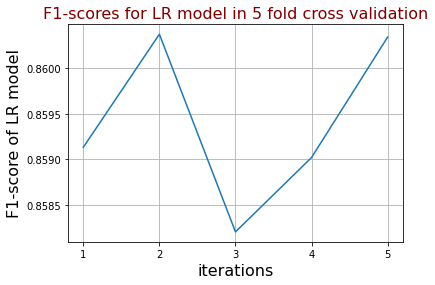

In [103]:
lst  =['1','2','3','4','5'] 
line_plot_2_lists(x=lst,y=LR_Score_Lst,title="F1-scores for LR model in 5 fold cross validation",x_label="iterations",y_label="F1-score of LR model")

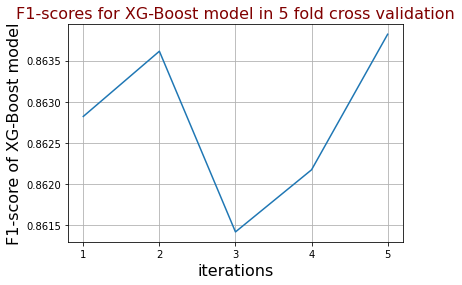

In [104]:
line_plot_2_lists(x=lst,y=xgb_Score_Lst,title="F1-scores for XG-Boost model in 5 fold cross validation",x_label="iterations",y_label="F1-score of XG-Boost model")

 I have selected the XG-Boost algorithms 

---------------

## 5.Model evaluation

<h3 style="color:rgb(92, 11, 10)"> 1. It will not be enough to split your data into train and test to justify the results of your model.</h3> 

<h3 style="color:rgb(92, 11, 10)">hyper parameter tunning for XG-Boost  </h3>

In [105]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

param_grid ={
 'max_depth':[3,10,15],
 'n_estimators':[200,300,400,500],
 'learning_rate' :[0.1,0.01]
}


base_estimator  =xgb.XGBClassifier(objective="binary:logistic",random_state=0)

gridsearch = GridSearchCV(estimator=base_estimator,param_grid=param_grid,cv=5,scoring='f1')

# now perform full fit on whole pipeline
gridsearch.fit(X_train_normalized,y_train.values.ravel())

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca..._onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
     

In [106]:
print("Best parameters from gridsearch: {}".format(gridsearch.best_params_))
print("CV score=%0.3f" % gridsearch.best_score_)

Best parameters from gridsearch: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}
CV score=0.863


<h3 style="color:rgb(92, 11, 10)"> 2. Plot the performance metrics and perform a critical analysis of them. </h3>

In [107]:
# Build the model with the best combination of the parameters 
best_classifier = xgb.XGBClassifier(objective="binary:logistic",learning_rate =0.1, n_estimators=500,max_depth=10, random_state=0)

#### how does the model work with the tuned parameters 

              precision    recall  f1-score   support

           0       1.00      0.61      0.76     19342
           1       0.76      1.00      0.86     23549

    accuracy                           0.83     42891
   macro avg       0.88      0.81      0.81     42891
weighted avg       0.87      0.83      0.82     42891



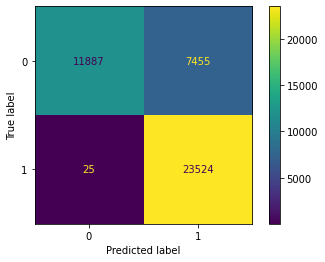

              precision    recall  f1-score   support

           0       1.00      0.62      0.76     19342
           1       0.76      1.00      0.86     23549

    accuracy                           0.83     42891
   macro avg       0.88      0.81      0.81     42891
weighted avg       0.87      0.83      0.82     42891



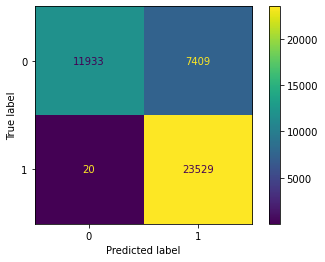

              precision    recall  f1-score   support

           0       1.00      0.61      0.76     19341
           1       0.76      1.00      0.86     23549

    accuracy                           0.82     42890
   macro avg       0.88      0.80      0.81     42890
weighted avg       0.87      0.82      0.81     42890



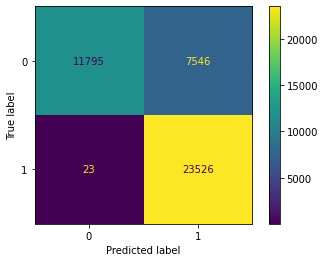

              precision    recall  f1-score   support

           0       1.00      0.61      0.76     19342
           1       0.76      1.00      0.86     23548

    accuracy                           0.82     42890
   macro avg       0.88      0.81      0.81     42890
weighted avg       0.87      0.82      0.82     42890



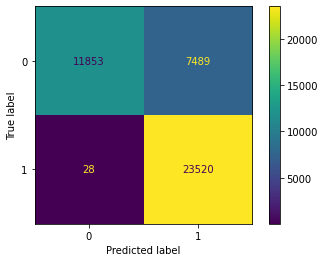

              precision    recall  f1-score   support

           0       1.00      0.62      0.76     19342
           1       0.76      1.00      0.86     23548

    accuracy                           0.83     42890
   macro avg       0.88      0.81      0.81     42890
weighted avg       0.87      0.83      0.82     42890



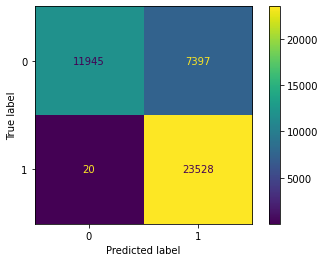

the f1-score in all iterations       : [0.86282277 0.86365555 0.86142692 0.8622175  0.8638408 ]
the mean of f1-scores                : 0.8627927087381213
the std  of f1-scores                : 0.0008989033718906614


In [108]:
best_xgb_mean,best_xgb_std,best_xgb_Score_Lst = apply_CV_F1(best_classifier,X_train_normalized,y_train.values.ravel())

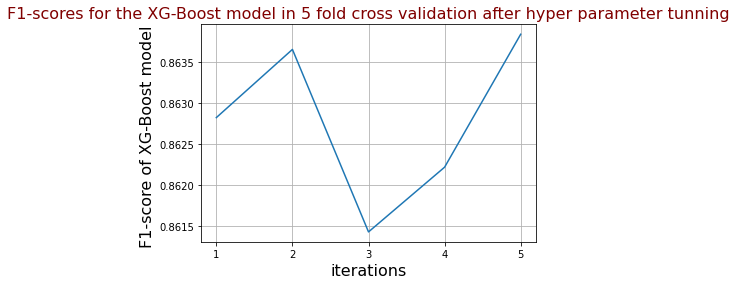

In [109]:
line_plot_2_lists(x=lst,y=best_xgb_Score_Lst,title="F1-scores for the XG-Boost model in 5 fold cross validation after hyper parameter tunning",x_label="iterations",y_label="F1-score of XG-Boost model ")

<h3 style="color:rgb(92, 11, 10)"> 3. Save your model for using it in the second part.</h3>

In [62]:
# fit the model on the train data 
static_classifier = xgb.XGBClassifier(objective="binary:logistic",learning_rate =0.1, n_estimators=500,max_depth=10, random_state=0)
static_classifier.fit(X_train_normalized,y_train.values.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [63]:
pickle.dump(static_classifier, open('Staitic_model.pkl', 'wb'))

#### read the saved model

In [64]:
static_model =pickle.load(open('Staitic_model.pkl', 'rb'))

#### check the accuracy of the model on the test test set (it is the first and last time to use the test set)

In [65]:
from sklearn.metrics import accuracy_score

pp = static_model.predict(X_test_normalized)

#calculate Accuracy score on the test data 
accuracy_score_value = accuracy_score(y_test, pp)

In [66]:
accuracy_score_value

0.8250270451747678

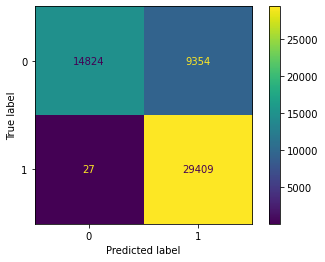

In [67]:
plot_report_confusionMatrix(pp,y_test)

## References 

[1] https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py

[2] https://www.geeksforgeeks.org/normalization-vs-standardization/

[3] https://hossainlab.github.io/dataviz/notebooks/SB01-Distribution%20Plots.html

[4] https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

[5] https://www.unb.ca/cic/datasets/dns-exf-2021.html

[6] https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/


